# [데이터사이언스 실무] 기말 과제 안내
## 제출 방법 안내
* 주제 : ABTest 수행능력 평가
* 과제 유형 : 실전 데이터분석 과제
* 제출 기한 : 2024. 6. 13. (금) 오후 11:59까지
* 제출 방법 : ecampus에 업로드
* 제출 양식 : ipynb 파일과 html로 변환한 파일을 압축한 파일(zip)
* 제출 파일명 : 학번_이름_기말과제.zip
## 과제 상세 설명
* 데이터셋 : 함께 첨부된 final_exam_dataset.csv
* 상황설정 : 미션 및 제약사항
    * 웹사이트 개편을 앞두고, 신규 디자인 배포 전에 AB테스트를 통해, 효과성을 확인하고 3가지 디자인 안 중에서 1가지를 채택해서 배포하려고 한다.
    * 디자인팀의 의뢰를 받아 ABTEST 를 진행하기로 했다.
    * ABTEST 적정 규모(기간, 샘플사이즈)를 정하고, MVT를 설계해야 한다.
    * 주어진 테스트 외에도 많은 테스트가 밀려있기 때문에 장기간 테스트할수 없고, 적정 테스터의 데이터가 확보되었을때, 중단해야한다.
    * 본 회사의 ABTEST 로그시스템은 어느정도 잘못 할당되는 오류가 있다고 한다. 데이터 전처리를 반드시 확인해야한다.
    * 클릭율을 향상시키면서, 매출은 보합 또는 성장하면 실험의 성공으로 판단하기로 했다.
    * MDE를 판단하기 위해 자문 및 리서치한 결과, 5% 정도(퍼센트 포인트 아님) 향상을 목표로 설계해야 함을 확인했다.
## 과제 일반지침
* 수업내용을 참고해서 Flow대로 코드와 보충설명(마크다운)을 작성합니다.
* 필요시 차트를 그려 설명에 설득력을 보강해주어야 합니다.
* 모수, 비모수, 연속형, 이산형 검정, ABT Pair-wise, MVT, 사후검정법을 모두 사용해서, 다양한 해석이 가능하도록 해야합니다.
* 테스트를 마치고, 마지막 해석을 텍스트로 총평해주면 됩니다.
## 기타 가이드
* 제출 기한을 반드시 엄수해주세요.
* 중간에 질문은 얼마든지 해주세요.
* 정답 보다는 ABTest를 진행하는 흐름을 이해하는것이 더 중요합니다.
* 틀리더라도 자신있게 하시면 만점입니다.

# 기말 과제 - 웹 UI 개선을 위한 A/B/C 테스트 분석 리포트

### 1. 환경 준비 및 데이터 불러오기

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.stats.power import TTestIndPower, NormalIndPower, FTestAnovaPower
import scipy.stats as stats
from math import ceil
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.power import FTestAnovaPower, GofChisquarePower
from sklearn.model_selection import ParameterGrid
from scipy.stats import chi2_contingency
import plotly.express as px
import plotly.graph_objects as go

#### 1.1 데이터 로드

In [2]:
# 데이터 파일 로드
file_path = "datasets/final_exam_dataset.csv"
df = pd.read_csv(file_path)
df.head()

,uno,created_at,variation,release,clicked,purchase_amount
0,A851560,2024-01-21 22:11:48.556739,A,legacy_design,0,0
1,A804684,2024-01-12 08:01:45.159739,A,legacy_design,0,0
2,B662046,2024-01-11 16:55:06.154213,B,new_design_001,0,0
3,B853997,2024-01-08 18:28:03.143765,B,new_design_001,0,0
4,A865431,2024-01-21 01:52:26.210827,A,legacy_design,1,238660


#### 1.2 기본 정보 출력

In [3]:
df.head()

,uno,created_at,variation,release,clicked,purchase_amount
0,A851560,2024-01-21 22:11:48.556739,A,legacy_design,0,0
1,A804684,2024-01-12 08:01:45.159739,A,legacy_design,0,0
2,B662046,2024-01-11 16:55:06.154213,B,new_design_001,0,0
3,B853997,2024-01-08 18:28:03.143765,B,new_design_001,0,0
4,A865431,2024-01-21 01:52:26.210827,A,legacy_design,1,238660


In [4]:
df.info()
# 585652 행 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585652 entries, 0 to 585651
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   uno              585652 non-null  object
 1   created_at       585652 non-null  object
 2   variation        585652 non-null  object
 3   release          585652 non-null  object
 4   clicked          585652 non-null  int64 
 5   purchase_amount  585652 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 26.8+ MB


In [5]:
df.describe(include='all')

,uno,created_at,variation,release,clicked,purchase_amount
count,585652,585652,585652,585652,585652.000000,585652.000000
unique,583653,571373,4,4,NaN,NaN
top,A638524,2024-01-03 23:43:15.636070,B,legacy_design,NaN,NaN
freq,2,3,147276,147239,NaN,NaN
mean,NaN,NaN,NaN,NaN,0.122948,31100.524427
std,NaN,NaN,NaN,NaN,0.328378,83249.255326
min,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,0.000000,0.000000
75%,NaN,NaN,NaN,NaN,0.000000,0.000000


### 2. 데이터 탐색 및 전처리

#### 2.1 결측치 확인 
* 결측치 없음

In [6]:
# 전체 결측치 개수 확인
df.isnull().sum()

# 결측치 비율 (%) 확인
(df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

uno                0.0
created_at         0.0
variation          0.0
release            0.0
clicked            0.0
purchase_amount    0.0
dtype: float64

#### 2.2 로그할당 오류 점검(사용자 중복체크)
* 중복된 사용자가 여러 그룹에 걸쳐 있으면 집단 간 독립성이 훼손되어 검정 결과가 왜곡될 수 있음
* 한 사용자가 A와 B에 동시에 속해 있으면 두 집단의 클릭률·매출이 연결되어 버려 통계 검정의 가정(독립성, 무작위성)이 깨짐
* 이는 Type I error(가짜 긍정)나 Type II error(가짜 부정)의 위험을 증가

In [7]:
user_group_counts = df.groupby('uno')['release'].nunique()
conflict_users = user_group_counts[user_group_counts > 1]
print(f"다중 그룹 할당 사용자 수: {len(conflict_users)}")

# 해당 사용자 확인
df[df['uno'].isin(conflict_users.index)].sort_values(by='uno')

다중 그룹 할당 사용자 수: 1998


,uno,created_at,variation,release,clicked,purchase_amount
11792,A630593,2024-01-22 14:59:22.051308,A,new_design_001,0,0
183371,A630593,2024-01-20 02:08:49.893878,A,legacy_design,0,0
96929,A630927,2024-01-07 02:14:17.405726,A,new_design_001,0,0
110634,A630927,2024-01-23 01:42:51.501851,A,legacy_design,0,0
201303,A631236,2024-01-18 21:27:53.859949,A,new_design_001,0,0
...,...,...,...,...,...,...
117312,B944815,2024-01-06 03:44:10.289493,B,legacy_design,0,0
122764,B945587,2024-01-08 00:20:56.575492,B,legacy_design,0,0
110093,B945587,2024-01-07 11:53:08.813744,B,new_design_001,1,237916
260695,B945966,2024-01-02 22:18:32.840038,B,new_design_001,0,0


#### 2.3 다중 그룹 사용자 제거
* 다중 그룹 사용자 데이터는 과감히 제거하고, 남은 유효한 사용자 기반으로 실험을 수행
* 이 처리가 끝나야 그룹 간 비교(CTR, Revenue) 및 통계 검정의 신뢰성이 확보됨

In [8]:
# 해당 사용자 제거
df_cleaned = df[~df['uno'].isin(conflict_users.index)]

print(f"다중 그룹 할당 사용자 수: {len(conflict_users)}")
print(f"제거 후 샘플 수: {len(df_cleaned)}")

다중 그룹 할당 사용자 수: 1998
제거 후 샘플 수: 581656


#### 2.4 오류데이터 정리

In [9]:
df.groupby(['variation', 'release']).size().reset_index()

,variation,release,0
0,A,legacy_design,145274
1,A,new_design_001,1928
2,B,legacy_design,1965
3,B,new_design_001,145311
4,C,new_design_002,145851
5,D,new_design_003,145323


In [10]:
# 데이터 오류로 판단할수 있으므로 제거
prep_df1 = pd.concat([
    df.query("variation == 'A' and release == 'new_design_001'"), 
    df.query("variation == 'B' and release == 'legacy_design'"),

])
print(f"df.shape : {df.shape} => prep_df.shape : {prep_df1.shape} 제거한 행 수: {df.shape[0] - prep_df1.shape[0]}")
df = df.drop(prep_df1.index)

df.shape : (585652, 6) => prep_df.shape : (3893, 6) 제거한 행 수: 581759


#### 2.4 이상 날짜 조건 확인
* 날짜별 로그 수 시각화
    * 이상치 없음

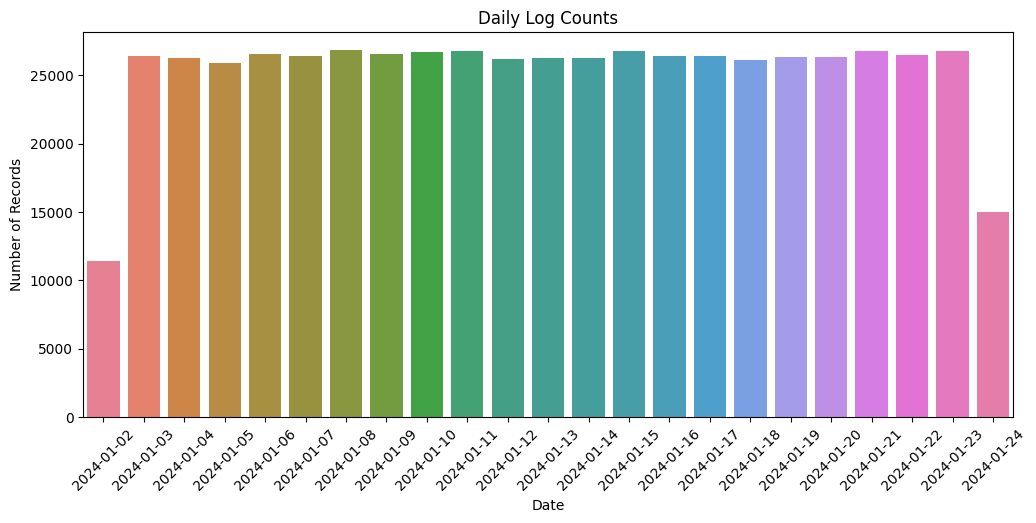

In [11]:
# 1. created_at을 datetime으로 변환
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# 2. 날짜만 추출한 새로운 열 생성
df['log_date'] = df['created_at'].dt.date

# 3. 일별 로그 수 집계
daily_counts = df['log_date'].value_counts().sort_index()

# 4. DataFrame으로 변환
daily_counts_df = daily_counts.reset_index()
daily_counts_df.columns = ['date', 'log_count']

# 5. Seaborn 시각화
plt.figure(figsize=(12, 5))
sns.barplot(data=daily_counts_df, x='date', y='log_count',  palette='husl', legend=False, hue='date')

plt.title("Daily Log Counts")
plt.xlabel("Date")
plt.ylabel("Number of Records")
plt.xticks(rotation=45)
plt.show()

#### 2.5 디자인별 노출 수 


In [12]:
df['release'].value_counts()

release
new_design_002    145851
new_design_003    145323
new_design_001    145311
legacy_design     145274
Name: count, dtype: int64

#### 2.6 디자인별 클릭률 평균

In [13]:
df.groupby('release')['clicked'].mean()

release
legacy_design     0.120386
new_design_001    0.118807
new_design_002    0.119800
new_design_003    0.132773
Name: clicked, dtype: float64

#### 2.7 디자인별 매출 평균

In [14]:
df.groupby('release')['purchase_amount'].mean()

release
legacy_design     30474.915009
new_design_001    29958.307926
new_design_002    29417.913494
new_design_003    34550.066576
Name: purchase_amount, dtype: float64

#### 2.8 클릭유무 분포 시각화

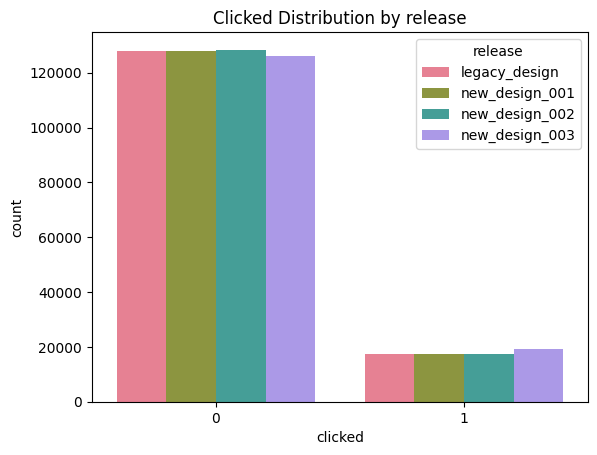

In [15]:
# 클릭 유무 분포
sns.countplot(data=df, x='clicked', hue='release', palette='husl')
plt.title("Clicked Distribution by release")
plt.show()

* 해석
    * 샘플 수는 그룹별로 유사 - 실험 설계의 랜덤할당(무작위화)이 비교적 잘 이루어진 것으로 추정 가능
    * 전체적으로 클릭률 자체가 낮은 구조이며, 테스트 대상 페이지가 전반적으로 유저 참여를 잘 유도하지 못할 수 있음
    * new_design_003의 클릭수가 약간 많아 보이지만, 시각적으로 아주 큰 차이는 아님 => 그룹 간 차이가 통계적으로 유의한지는 후속 분석 필요 (비율 검정 등)

#### 2.9 매출 분포 시각화

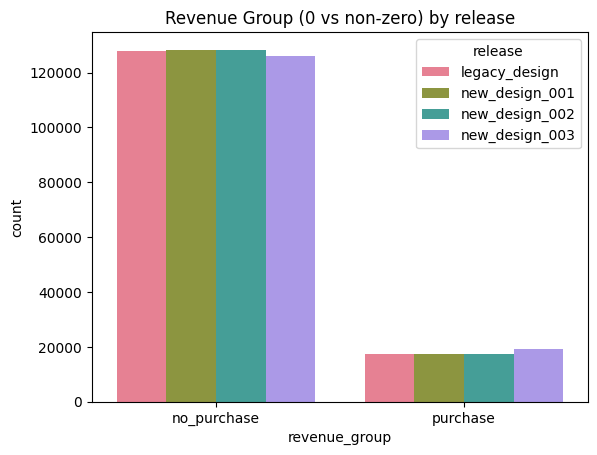

In [16]:
# 매출 0 vs 1 이상 분리
df['revenue_group'] = np.where(df['purchase_amount'] == 0, 'no_purchase', 'purchase')

# 그룹별 구매자 수 분포
sns.countplot(data=df, x='revenue_group', hue='release', palette='husl')
plt.title("Revenue Group (0 vs non-zero) by release")
plt.show()

* 해석
    * 모든 그룹에서 no_purchase(매출 0인 경우)의 수가 purchase(매출 > 0인 경우)보다 훨씬 많음 = 즉, 구매율 자체가 매우 낮음
        * 이는 앞서 본 클릭률이 낮은 것과도 연결되며, 유저의 전환(CTR → Purchase)이 전반적으로 저조함을 의미함
    * 그룹 간 구매 비율 차이가 일부 존재
        * purchase 구간을 보면, new_design_003이 상대적으로 가장 높아 보임
        * 즉, new_design_003 사용자의 구매 전환율이 다른 디자인보다 약간 높을 가능성이 있음


#### 2.10 매출 박스플롯 시각화

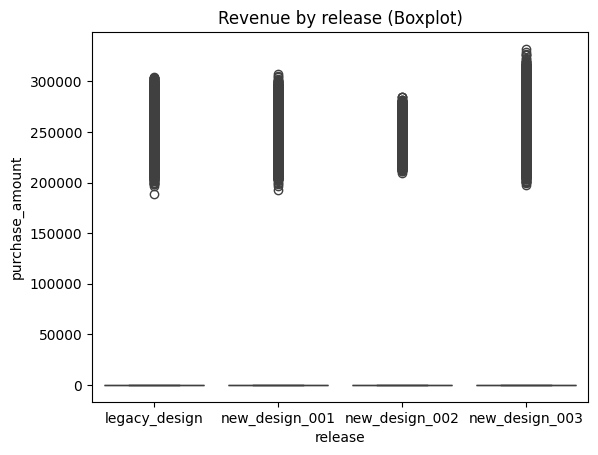

In [17]:

sns.boxplot(data=df, x='release', y='purchase_amount', hue='release', palette='husl')
plt.title("Revenue by release (Boxplot)")
plt.show()

* 해석
    * 박스플롯의 상자(=IQR) 부분이 거의 바닥에 붙어 있고, 대부분의 데이터가 0 또는 매우 작은 값에 집중되어 있음
    * 대부분의 사용자는 적은 금액을 구매하지만, 소수의 고액 구매자가 존재함
    * 다수의 이상치(Outlier)가 존재
    * 그룹 간 구매 패턴의 분포 범위는 유사
        * 하지만 new_design_003은 위쪽 이상치 범위가 약간 더 넓게 분포되어 있어, 고액 구매자들이 더 많이 포함되었을 가능성이 있음

#### 2.11 매출 > 0 사용자만 별도 박스플롯 시각화

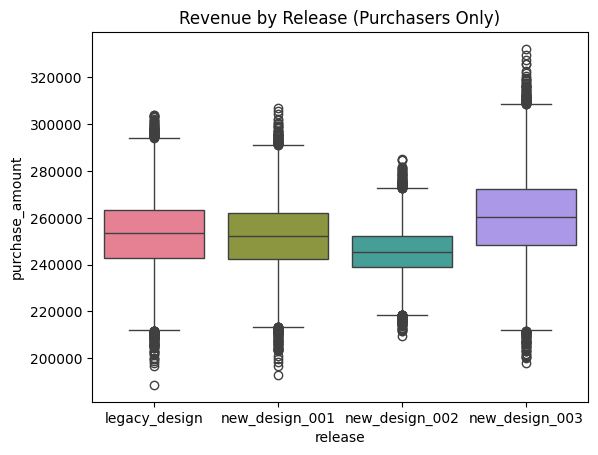

In [18]:
paid = df[df['purchase_amount'] > 0]

sns.boxplot(data=paid, x='release', y='purchase_amount', hue='release', palette='husl')
plt.title("Revenue by Release (Purchasers Only)")
plt.show()

* 해석
    * new_design_003 디자인을 본 사용자가 구매 금액의 중앙값이 가장 높았음 
    * new_design_003은 전체 분포도 더 넓고 상위 이상치도 더 큼 → 고액 구매 가능성이 더 높음
    * new_design_002는 중앙값도 가장 낮고, 상하 IQR도 가장 작음 →  전반적으로 매출이 가장 낮음
    * 이상치는 전체 그룹에서 공통적으로 존재

#### 2.12 변수유형 정의

In [19]:
# 변수 유형 자동 분류 예시
categorical_cols = df.select_dtypes(include='object').columns.tolist()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("범주형 변수:", categorical_cols)
print("수치형 변수:", numeric_cols)

범주형 변수: ['uno', 'variation', 'release', 'log_date', 'revenue_group']
수치형 변수: ['clicked', 'purchase_amount']


### 3. AB Test 설계 정보

- 실험 방식: A/B/C → 다변량 AB 테스트(MVT)
- ABTEST 적정 규모(기간, 샘플사이즈)를 정함
- 효과 측정 지표: 클릭률 (CTR)
- 기준(legacy_design) 클릭률: 12%
- 기존 클릭률이 12%였다면, 이를 5% 상승시킨다는 것은 12% × 1.05 = 12.6% 가 된다는 뜻
- 성공조건 : 클릭율을 향상시키면서, 매출은 보합 또는 성장하는 경우
- 목표 개선율 (MDE): +5% (상대)
    - MDE를 정해놓으면, 그 크기에 맞춰 샘플 사이즈(노출 수)를 산출하여 실험을 설계하게 된다.
    - 예를 들어 MDE를 5%로 잡으면, “만약 실제 효과가 (상대적으로) 5% 이상 차이가 있을 때 실험에서 이를 유의미하게 발견할 수 있도록” 필요한 참여자(또는 노출) 수를 계산합니다.
- 유의수준 (α): 0.05
- 검정력 (1-β): 0.8
- 그룹 수: 3개 (new_design_001, new_design_002, new_design_003)

In [20]:
# 그룹별 클릭률
group_ctr = df.groupby('release')['clicked'].mean().sort_values(ascending=False)
print("그룹별 평균 클릭률 (CTR):")
print(group_ctr)

그룹별 평균 클릭률 (CTR):
release
new_design_003    0.132773
legacy_design     0.120386
new_design_002    0.119800
new_design_001    0.118807
Name: clicked, dtype: float64


* 해석
    * new_design_003이 CTR 13.28%로 가장 높았고, legacy_design은 12.04%, 따라서 상대적으로 10.4% 증가.
    * 성공 조건 만족 여부 : 기준은 12% → 12.6% 이상 되어야 성공. 
    * new_design_003: 13.28% → 성공 기준 충
    * 다른 디자인은 모두 실패 기준에 해당.
    * 통계적으로 유의한가?
        * 현재 코드는 CTR 평균만 보여주고 있고, 유의성 검정은 포함되지 않음.
        * 이를 보완하려면 z-test / chi-squared test / proportions_ztest 등의 추가 검정이 필요합니다.

### 4. 샘플 사이즈 계산

* 이산형일때

In [38]:
# 1.5% point의 전환율 상승의 비즈니스 목표설정이 있었으므로,
# 이에 맞춰 효과크기를 계신.
# effect size가 비율일 경우 p1
effect_size = sms.proportion_effectsize(0.12, 0.126) # 실험설계에 맞게 수정

sample_size = sms.NormalIndPower().solve_power( # 독립검정, 독립 이항검정을 위한 필요 샘플 사이즈를 반환
    effect_size=effect_size, # 효과크기 
    power=0.8, # 검정력 80%
    alpha=0.05, # 유의수준 5%
    ratio=1 # 대조와 처치의 비율 1:1
)                                                  

sample_size = ceil(sample_size) # 샘플사이즈는 정수형이 맞으므로 소수점 제거

print(f"각 그룹별 필요 샘플사이즈 : {sample_size}")

각 그룹별 필요 샘플사이즈 : 47031


* 해석 : 그룹별 노출는 모두 그 이상이므로 샘플사이즈 만족

* 연속형일때

In [40]:
effect_size = (12500 - 12700) / 3000 # 200원 상승의 효과를 기대
print("effect_size : ", effect_size)
sample_size = sms.TTestIndPower().solve_power( # T분포 사용, 연속형 지표에 대한 독립 샘플 t-검정에 맞춘 클래스
    effect_size, # 효과크기 
    power=0.8, # 검정력 80%
    alpha=0.05, # 유의수준 5%
    ratio=1 # 대조와 처치의 비율 1:1
)                                                  

sample_size = ceil(sample_size) # 샘플사이즈는 정수형이 맞으므로 소수점 제거

print(f"각 그룹별 필요 샘플사이즈 : {sample_size}")

effect_size :  -0.06666666666666667
각 그룹별 필요 샘플사이즈 : 3533


* 모수를 가정하는 테스트는 위 방법으로 간단히 샘플사이즈 산출이 가능하지만,
* 정규성 가정, 등분산성 가정이 어려운 경우 비모수 검정을 위한 테스트 설계를 해야함. - 샘플을 확보하기 어려운 케이스
    * 정규성, 등분산성이 참이여야 한다.
    * 그렇지 않은 경우 샘플이 모집단을 대신할 수 없다.
    * 순서와 순위의 관계를 따져서 활용한다. - 비모수 검정

### 5. MVT

#### 5.1 이산형 (Chi-Square)

In [41]:
def estimate_sample_size_for_discrete_mvt(effect_size, alpha=0.05, power=0.8, num_tests=3):
    # 본페로니 보정 (Bonferroni Correction) 적용
    # 다중 비교로 인한 1종 오류(α) 누적을 방지
    # 각 그룹 간 비교의 유의수준을 엄격하게 조정
    adjusted_alpha = alpha / num_tests 
    
    # 검정력 분석 객체 생성
    power_analysis = GofChisquarePower() # 범주형 변수 간 독립성 검정
    
    return ceil(power_analysis.solve_power(
        effect_size=effect_size,
        alpha=adjusted_alpha,
        power=power
    ))

In [42]:
sample_size = estimate_sample_size_for_discrete_mvt(effect_size=0.015, alpha=0.05, power=0.8, num_tests=3)
sample_size

46530

* 디자인별 노출 수
    * legacy_design     147239
    * new_design_001    147239
    * new_design_002    145851
    * new_design_003    145323
* 샘플사이즈보다 각 그룹이 모수가 큼

#### 5.2 연속형 (ANOVA)

In [25]:
# 연속형 (ANOVA)
def estimate_sample_size_for_continuous_mvt(effect_size, alpha=0.05, power=0.8, num_tests=4):
    # 본페로니 교정 적용
    # ANOVA의 특성상 모든 쌍 간 비교를 고려해야 하므로,
    # 총 비교 쌍 수 = k * (k - 1) / 2 → 각 쌍에 적용될 alpha를 보정해 다중 비교 오류 방지

    adjusted_alpha = alpha / (num_tests * (num_tests - 1) / 2)
    
    return ceil(FTestAnovaPower().solve_power(effect_size=effect_size, 
                                               alpha=adjusted_alpha, 
                                               k_groups=num_tests, 
                                               power=power))

In [26]:
sample_size = estimate_sample_size_for_continuous_mvt(effect_size=0.02, alpha=0.05, power=0.8, num_tests=6) # A,B,C,D가 있을 경우의 경우의 수는 6
sample_size

52703

### 6. 이산형 분석

In [27]:
# 분할표 만들기
contingency_table = df.pivot_table(index='release', columns='clicked', aggfunc='size')
contingency_table

clicked,0,1
release,,
legacy_design,127785,17489
new_design_001,128047,17264
new_design_002,128378,17473
new_design_003,126028,19295


#### 6.1 ABT - pair-wise

* A, B, C에 대해서도 테스트를 하지만
* A B, B C, C A 에 대한 테스트도 필요하다.

In [28]:
# group2 - group 1 신뢰구간 계산하기
def calc_proportion_test_ci(n1, p1, n2, p2, alpha=0.05):
    # minitab : https://support.minitab.com/ko-kr/minitab/18/help-and-how-to/statistics/basic-statistics/how-to/2-proportions/methods-and-formulas/methods-and-formulas/
    se = np.sqrt( p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2 )
    diff_prop = p2 - p1
    cl_ll, cl_ul = diff_prop + np.array([-1, 1]) * stats.norm.ppf(1 - alpha / 2) * se
    return cl_ll, cl_ul

In [29]:
def analysis_pair_wise_abt(df, group1, group2):
    filtered_df = df[(df['release'] == group1) | (df['release'] == group2)]
    group1_size = filtered_df[filtered_df['release'] == group1]['clicked'].values.size
    group1_cvr = filtered_df[filtered_df['release'] == group1]['clicked'].values.sum() / group1_size
    group2_size = filtered_df[filtered_df['release'] == group2]['clicked'].values.size
    group2_cvr = filtered_df[filtered_df['release'] == group2]['clicked'].values.sum() / group2_size

    diff_mean = group2_cvr - group1_cvr
    # 신뢰구간 계산
    cl_ll, cl_ul = calc_proportion_test_ci(group1_size, group1_cvr, group2_size, group2_cvr)
    # 두비율 검정
    z_stat, pval = proportions_ztest([group1_cvr * group1_size, group2_cvr * group2_size], nobs=[group1_size, group2_size])
    
    return {
        'group1': group1,
        'group2': group2,
        '평균차이': diff_mean,
        '신뢰구간_하한': cl_ll,
        '신뢰구간_상한': cl_ul,
        'z_통계량': z_stat,
        'p값': pval
    }

In [30]:
# 그룹 조합 리스트 생성
from itertools import combinations
groups = sorted(df['release'].unique().tolist())
pairwise_combinations = list(combinations(groups, 2))
pairwise_combinations

[('legacy_design', 'new_design_001'),
 ('legacy_design', 'new_design_002'),
 ('legacy_design', 'new_design_003'),
 ('new_design_001', 'new_design_002'),
 ('new_design_001', 'new_design_003'),
 ('new_design_002', 'new_design_003')]

In [31]:
stats_df = pd.DataFrame([
    analysis_pair_wise_abt(df, *comb) 
    for comb in pairwise_combinations
])
stats_df

,group1,group2,평균차이,신뢰구간_하한,신뢰구간_상한,z_통계량,p값
0,legacy_design,new_design_001,-0.001579,-0.003939,0.000781,1.311608,1.896526e-01
1,legacy_design,new_design_002,-0.000586,-0.002948,0.001776,0.486296,6.267577e-01
2,legacy_design,new_design_003,0.012387,0.009969,0.014804,-10.041135,1.005107e-23
3,new_design_001,new_design_002,0.000993,-0.001362,0.003348,-0.826583,4.084736e-01
4,new_design_001,new_design_003,0.013966,0.011555,0.016377,-11.352254,7.227482e-30
5,new_design_002,new_design_003,0.012973,0.010560,0.015386,-10.537441,5.805725e-26


#### 6.2 MVT - 사후분석

In [32]:
# 카이제곱 검정 수행
from statsmodels.sandbox.stats.multicomp import multipletests
contingency_table = pd.crosstab(df['release'], df['clicked'])
contingency_table

clicked,0,1
release,,
legacy_design,127785,17489
new_design_001,128047,17264
new_design_002,128378,17473
new_design_003,126028,19295


In [33]:
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
rejects, _, _, _ = multipletests(stats_df['p값'], method='bonferroni', alpha=0.05)

# 결과 출력
print(f"Chi2 통계량: {chi2}")
print(f"p값: {p}")
if rejects.all():
    print("귀무가설 기각: 전체 그룹 간의 차이가 통계적으로 유의미")
else:
    print("귀무가설 채택: 전체 그룹 간의 차이가 통계적으로 유의미하지 않음")

Chi2 통계량: 175.45542619509519
p값: 8.449211367972193e-38
귀무가설 채택: 전체 그룹 간의 차이가 통계적으로 유의미하지 않음


### 7. 연속형 분석

#### 7.1 정규성 검정

In [34]:
# Shapiro-Wilk 정규성 검정 수행
stat, p_value = stats.shapiro(df.purchase_amount)

# 결과 출력
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")

# 유의 수준 설정
alpha = 0.05

# 가설 검정
if p_value > alpha:
    print("귀무가설 채택: 데이터가 정규분포를 따름")
else:
    print("귀무가설 기각: 데이터가 정규분포를 따르지 않음")

Shapiro-Wilk Test Statistic: 0.3941733440718703
P-value: 2.0884128344918207e-209
귀무가설 기각: 데이터가 정규분포를 따르지 않음


/Users/choiwooyeon/opt/anaconda3/envs/aibp/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 581759.
  res = hypotest_fun_out(*samples, **kwds)


#### 7.2 등분산성 검정
* 정규성을 만족하지 않으면 등분산성을 따지지 않는다.

### 8. 검정단계

#### 8.1 모집단 정규 분포 가정 (모수적 방법)

In [35]:
def analysis_pair_wise_abt_by_parametric(df, group1, group2, alpha=0.05, eqvar=True):
    filtered_df = df[(df['release'] == group1) | (df['release'] == group2)]
    n1 = filtered_df[filtered_df['release'] == group1]['clicked'].values.size
    n2 = filtered_df[filtered_df['release'] == group2]['clicked'].values.size
    mu1 = filtered_df[filtered_df['release'] == group1]['clicked'].values.sum() / n1
    mu2 = filtered_df[filtered_df['release'] == group2]['clicked'].values.sum() / n2
    std1 = np.sqrt(filtered_df[filtered_df['release'] == group1]['clicked'].values.sum() / n1)
    std2 = np.sqrt(filtered_df[filtered_df['release'] == group2]['clicked'].values.sum() / n2)
    
    if eqvar:
        # 등분산성을 만족하는 경우, Student's t-test 수행
        t_stat, pval = stats.ttest_ind(
            filtered_df[filtered_df['release'] == group1]['clicked'],
            filtered_df[filtered_df['release'] == group2]['clicked'],
            equal_var=True
        )
    else:
        # 등분산성을 만족하지 않는 경우, Welch's t-test 수행
        t_stat, pval = stats.ttest_ind(
            filtered_df[filtered_df['release'] == group1]['clicked'],
            filtered_df[filtered_df['release'] == group2]['clicked'],
            equal_var=False
        )
        
    diff_mean = mu1 - mu2
    se_diff= np.sqrt((std1**2 / n1) + (std2**2 / n2))
    z_stat = diff_mean / se_diff
    cl_ll = diff_mean - stats.norm.ppf(1 - alpha/2) * se_diff
    cl_ul = diff_mean + stats.norm.ppf(1 - alpha/2) * se_diff
    # pval = 2 * (1 - stats.norm.cdf(abs(z_stat)))

    return {
        'group1': group1,
        'group2': group2,
        '평균차이': diff_mean,
        '신뢰구간_하한': cl_ll,
        '신뢰구간_상한': cl_ul,
        'z_통계량': z_stat,
        'p값': pval
    }

In [36]:
stats_df2 = pd.DataFrame([analysis_pair_wise_abt_by_parametric(df, *comb) for comb in pairwise_combinations])
stats_df2

,group1,group2,평균차이,신뢰구간_하한,신뢰구간_상한,z_통계량,p값
0,legacy_design,new_design_001,0.001579,-0.000936,0.004094,1.230678,1.896538e-01
1,legacy_design,new_design_002,0.000586,-0.001932,0.003104,0.456159,6.267591e-01
2,legacy_design,new_design_003,-0.012387,-0.014974,-0.009800,-9.384211,9.967047e-24
3,new_design_001,new_design_002,-0.000993,-0.003502,0.001516,-0.775716,4.084754e-01
4,new_design_001,new_design_003,-0.013966,-0.016545,-0.011387,-10.614288,7.128135e-30
5,new_design_002,new_design_003,-0.012973,-0.015555,-0.010391,-9.848772,5.746800e-26
